![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Tutorial on CARRA anomalies with respect to climate mean

### About

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse climatologies and trends in near-surface air temperature. The tutorial comprises the following steps:

1. Search, download and view data
2. Calculate a 30 years climate mean for ERA5 and CARRA
3. Visualise time series anomalies on a given point in the middle of Greenland

This tutorial makes use of the climate means product from the [CARRA reanalysis](https://climate.copernicus.eu/copernicus-arctic-regional-reanalysis-service), that will include daily and monthly means. The data set is not available at the time of writing this tutorial, but it will be available soon.


![logo](./img/climatology_banner.png)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## 1. Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Install CDS API

To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [10]:
#!pip install cdsapi

#### Import libraries

We will be working with data in NetCDF and grib format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [83]:
# CDS API
import cdsapi
import os

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from pathlib import Path
from datetime import datetime
import pandas as pd

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()


import warnings
warnings.filterwarnings('ignore') #turn off some warnings

#### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [12]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
#Export your env key from your environment. It is safer than writing in in a public notebook
# Use commands
# export CDS_API_KEY=your_key
# export CDS_UID=your_uid_key
CDS_UID=os.getenv("CDS_UID")
CDS_API_KEY=os.getenv("CDS_API_KEY")
KEY=f'{CDS_UID}:{CDS_API_KEY}'
#KEY = '##################################'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [13]:
DATADIR = './CARRA'

#### Search for data

To search for data, visit the CDS website: http://cds.climate.copernicus.eu.
Here you can search for ERA5 and CARRA data using the search bar. The ERA5 data we need for this tutorial is the [ERA5 monthly averaged data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The CARRA data we need are the CARRA monthly means of daily means. ERA5 is the 5th version of the ECMWF Reanalysis dataset. CARRA is a Reanalysis data set for the arctic that is available from 1990 to the present, and it is updated on a monthly basis with 2 months delay.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Monthly averaged reanalysis`
- Variable: `2m temperature`
- Year: `1993 to 2022`
- Month: `all`
- Time: `00:00` (default)
- Geographical area: `Greenland` 
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

#### Download data for ERA5

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [14]:
c = cdsapi.Client(url=URL, key=KEY)

year_ini = 1993 #first year
year_end  = 2022 #last year
years_to_retrieve = [str(i) for i in range(year_ini,year_end+1)]

area_greenland = [85,-75,60,-10] # this is to limit the ERA5 data to this polygon. Otherwise it will download the whole world
ERA5_file = os.path.join(DATADIR,'era5_monthly_t2m_greenland_'+str(year_ini)+'_'+str(year_end)+'.nc')
if not os.path.isfile(ERA5_file):
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': years_to_retrieve,
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': area_greenland,
        'format': 'netcdf',
    },
    ERA5_file)
else:
    print(f"{ERA5_file} already downloaded")

./CARRA/era5_monthly_t2m_greenland_1993_2022.nc already downloaded


#### Download data for CARRA
Currently the CARRA data is not yet available in CDS.
Instructions to be completed below when the data is available in CDS are included below

```
yearStart = 1992
yearEnd = 2022

def fetch_one_month(month, year, days, domain):
    c.retrieve(
        'reanalysis-carra-single-levels',
        {
            'format': 'grib',
            'domain': domain ,
            'level_type': 'surface_or_atmosphere',
            'variable': '2m_temperature',
            'product_type': 'moda',
            'year': year,
            'month': month,
            'day': days,
            'time': [
                '00:00', '03:00', '06:00',
                '09:00', '12:00', '15:00',
                '18:00', '21:00',
            ],
        },
        os.path.join(DATADIR,"monthly_means",'monthly_mean_no-ar-cw_sfc_'+str(year)+"{:02d}".format(month)+'.grib2'))
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(1,13)):
        if year == yearStart and month < monthStart:
            # Before the start date.
            continue
        if year == yearEnd and month > monthEnd:
            # After end date.
            break

        print ("Data will be fetched for ", year, month)
        fetch_one_month(month, year, days, domain)

    
```


For the moment the monthly means are available in a local directory named `monthly_means_carra`.


In [36]:
#### We select now a point in the middle of Greenland
t2m_carra_yearly = os.path.join(DATADIR,"monthly_means_carra","monthly_mean_no-ar-cw_an_sfc_199301.grib2")

CARRA_ds = xr.open_dataset(t2m_carra_yearly)

# Since we want a point in the middle of Greenland we select a point with index 775, 430
# given the grid dimensions of CARRA west domain
nx = CARRA_ds.sizes["x"]
ny = CARRA_ds.sizes["y"]

#The following point is selected based on the dimensions of the grid
# The grid is 1069 x 1269 for the west domain.
# this point is completely arbitrary, and intended to be somewhere in the middle of Greenland
# The user can change these numbers if desired
# An example is shown below
#x_ind = 775
#y_ind = 430

x_ind = 500
y_ind = 630
print(f"Grid dimensions of the CARRA files: ({nx},{ny})")
print(f"Points selected: ({x_ind},{y_ind})")

#CARRA_da = CARRA_ds['t2m']

#CARRA = CARRA_da - 273.15
#CARRA = CARRA.assign_attrs(CARRA_da.attrs)
#CARRA.attrs['units'] = 'deg C'

print("Coordinates of the selected point")
print(CARRA_ds.latitude[y_ind,x_ind].data)
print(CARRA_ds.longitude[y_ind,x_ind].data)
#mean_temp_point=CARRA_ds["t2m"][775,430].data.item()
#print(f"Annual mean on the point: {mean_temp_point}")
sel_lat = CARRA_ds.latitude[y_ind,x_ind]
sel_lon = CARRA_ds.longitude[y_ind,x_ind]

Grid dimensions of the CARRA files: (1069,1269)
Points selected: (500,630)
Coordinates of the selected point
71.89494549515084
321.5395890085085


### In case the user wants to select their own latitude and longitude we provide an example below

Latitude: 71.89494549515084, Longitude: 321.5395890085085


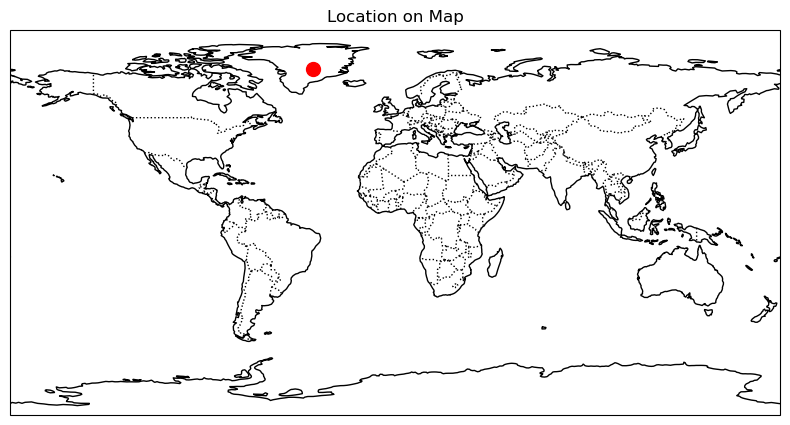

In [33]:
# The following map shows the select point

lat = CARRA_ds.latitude[y_ind,x_ind].data
lon = CARRA_ds.longitude[y_ind, x_ind].data
print(f"Latitude: {lat}, Longitude: {lon}")

# Create a plot
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add features to the map
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the point
ax.plot(lon, lat, 'ro', markersize=10, transform=ccrs.PlateCarree())
ax.set_title('Location on Map')
plt.show()




In [34]:
### Now supposed the user wants  to select a different latitude and longitude

from scipy.spatial import cKDTree
# Flatten the latitude and longitude arrays
latitudes = CARRA_ds.latitude.data.ravel()
longitudes = CARRA_ds.longitude.data.ravel()

# Create a KDTree for fast spatial queries
tree = cKDTree(list(zip(latitudes, longitudes)))

# Query the tree for the nearest point

desired_lat = 70.0  # example latitude
desired_lon = -50.0  # example longitude

_, idx = tree.query([desired_lat, desired_lon])

# Convert the 1D index back to 2D indices
y_ind_nearest, x_ind_nearest = np.unravel_index(idx, CARRA_ds.latitude.shape)

print(f"Nearest indices: x_ind = {x_ind_nearest}, y_ind = {y_ind_nearest}")
print(f"Nearest latitude: {CARRA_ds.latitude[y_ind_nearest, x_ind_nearest].data}")
print(f"Nearest longitude: {CARRA_ds.longitude[y_ind_nearest, x_ind_nearest].data}")

Nearest indices: x_ind = 0, y_ind = 1268
Nearest latitude: 77.8319647566982
Nearest longitude: 250.36511830484332


#### We save below the CARRA data in a pandas dataframe to generate the time series on the specific point
#### A pandas dataframe is the main data a structure used in the pandas library. It is equivalent to have an excel sheet for the data.
#### The data is saved in columns with date and t2m (for surface temperature)

In [92]:
my_cols=["date","t2m"] 
ts_carra_df = pd.DataFrame(columns=my_cols)
for file_path in Path("CARRA/monthly_means_carra").glob('monthly_mean_no-ar-cw_an_sfc_??????.grib2'):
    ds = xr.open_dataset(file_path)
    t2_da = ds["t2m"] - 273.15
    date_save = pd.to_datetime(ds["time"].values)
    t2_point = t2_da[y_ind,x_ind].item()
    #t2_point_anomaly = t2_point - mean_temp_point
    data_row = pd.DataFrame({"date":[date_save],"t2m":[t2_point]},columns=my_cols)
    ts_carra_df=pd.concat([ts_carra_df,data_row],ignore_index=True)
    del ds
    del data_row
print(ts_carra_df)



          date        t2m
0   2022-10-01 -25.339905
1   2021-10-01 -34.030289
2   2001-10-01 -30.799835
3   2020-10-01 -26.495667
4   1993-08-01 -17.022369
..         ...        ...
355 2019-12-01 -42.087906
356 2002-10-01 -30.128647
357 1997-04-01 -30.259460
358 2010-08-01 -12.506470
359 2022-05-01 -24.826599

[360 rows x 2 columns]


In [93]:
#Calculate the yearly mean and create a column with the t2m anomaly
mean_from_df = ts_carra_df[["t2m"]].mean().iloc[0]
ts_carra_df["t2m_anomaly"] = ts_carra_df["t2m"] - mean_from_df


In [94]:
ts_carra_df

,date,t2m,t2m_anomaly
0,2022-10-01,-25.339905,3.440830
1,2021-10-01,-34.030289,-5.249554
2,2001-10-01,-30.799835,-2.019100
3,2020-10-01,-26.495667,2.285069
4,1993-08-01,-17.022369,11.758366
...,...,...,...
355,2019-12-01,-42.087906,-13.307171
356,2002-10-01,-30.128647,-1.347912
357,1997-04-01,-30.259460,-1.478725
358,2010-08-01,-12.506470,16.274265


#### Plot the time series data
We plot below a time series of the data using matplotlib


In [95]:
# The part below makes the dates appear in the plot
#ts_carra_df.set_index('date', inplace=True)
#ts_carra_df.sort_index(inplace=True)

#### Now we plot the 30 years anomaly

In [96]:
#ts_carra_df['t2m_anomaly'].plot(
#    figsize=(14,8),
#    fontsize=14,
#    legend=['CARRA'],
#    xlabel='\nYear',
#    ylabel='Temperature (Celcius)',
#    title='\nNear surface temperature anomaly for central Greenland from 1992 to 2022\n',
#    linestyle ="-"
#    )

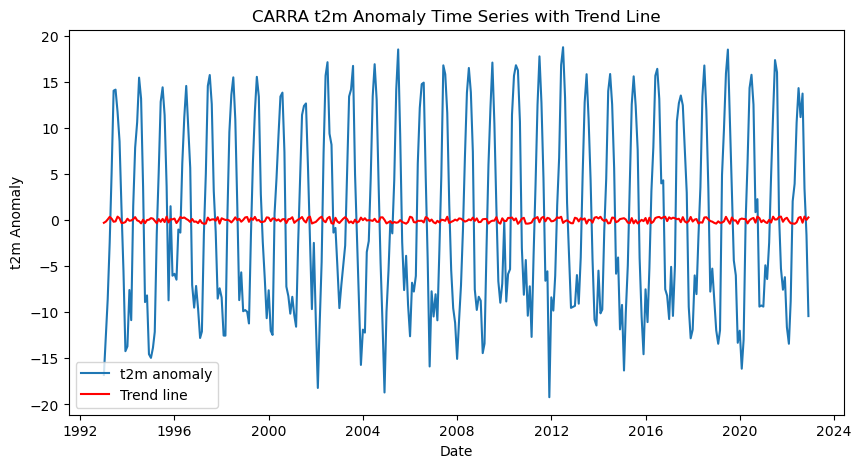

In [115]:
# Plot the time series

# Ensure the date column is in datetime format
ts_carra_df['date'] = pd.to_datetime(ts_carra_df['date'])

# Sort the dataframe by date
ts_carra_df = ts_carra_df.sort_values(by='date')
plt.figure(figsize=(10, 5))
plt.plot(ts_carra_df['date'], ts_carra_df['t2m_anomaly'], label='t2m anomaly')

# Compute the trend line
z = np.polyfit(ts_carra_df.index, ts_carra_df['t2m_anomaly'], 1)  # Fit a 1st degree polynomial (a line)
p = np.poly1d(z)

# Add trend line to the plot
plt.plot(ts_carra_df['date'], p(ts_carra_df.index), 'r', label='Trend line')

# Customize plot
plt.xlabel('Date')
plt.ylabel('t2m Anomaly')
plt.title('CARRA t2m Anomaly Time Series with Trend Line')
plt.legend()

# Show the plot
plt.show()

#### we plot below the near surface temperature for comparison

In [98]:
#ts_carra_df['t2m'].plot(
#    figsize=(14,8),
#    fontsize=14,
#    legend=['CARRA'],
#    xlabel='\nYear',
#    ylabel='Temperature (Celcius)',
#    title='\nNear surface temperature for central Greenland from 1992 to 2022\n',
#    linestyle ="-"
#    )

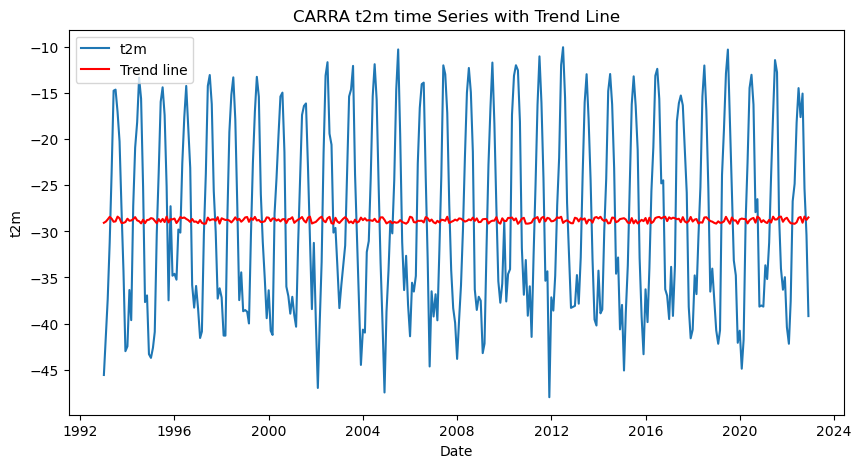

In [114]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(ts_carra_df['date'], ts_carra_df['t2m'], label='t2m')

# Compute the trend line
z = np.polyfit(ts_carra_df.index, ts_carra_df['t2m'], 1)  # Fit a 1st degree polynomial (a line)
p = np.poly1d(z)

# Add trend line to the plot
plt.plot(ts_carra_df['date'], p(ts_carra_df.index), 'r', label='Trend line')

# Customize plot
plt.xlabel('Date')
plt.ylabel('t2m')
plt.title('CARRA t2m time Series with Trend Line')
plt.legend()

# Show the plot
plt.show()

#### Now we calculate the near surface temperature anomaly for ERA5

In [106]:
t2m_era5_monthly = os.path.join(DATADIR,"era5_monthly_t2m_greenland_1993_2022.nc")

ERA5_ds = xr.open_dataset(t2m_era5_monthly)
ERA5_da = ERA5_ds['t2m']

ERA5 = ERA5_da - 273.15
ERA5 = ERA5.assign_attrs(ERA5_da.attrs)
ERA5.attrs['units'] = 'deg C'

In [107]:
# Selecting the nearest point in ERA5 data to the point we selected in the CARRA data
era5_lat = ERA5["latitude"].sel(latitude=sel_lat,method="nearest").values.item()
lat_index = np.abs(ERA5['latitude'] - era5_lat).argmin().values.item()
era5_lon = ERA5['longitude'].sel(longitude=sel_lon, method='nearest').values.item()
lon_index = np.abs(ERA5['longitude'] - era5_lon).argmin().values.item()


In [108]:
ERA5_middle_point = ERA5.isel(latitude=lat_index, longitude=lon_index)#,time=time_index)


In [109]:
# Converting the ERA5 data in the same point to a pandas dataframe for easier plotting
ERA5_df = ERA5_middle_point.to_dataframe()

In [110]:
# Calculating the t2m anomaly for ERA5
ERA5_df["t2m_anomaly"] = ERA5_df["t2m"] - ERA5_df["t2m"].mean()

In [82]:
#ERA5_middle_point
#ERA5_df['t2m_anomaly'].plot(
#    figsize=(14,8),
#    fontsize=14,
#    legend=['ERA5'],
#    xlabel='\nYear',
#    ylabel='Temperature (Celcius)',
#    title='\n ERA5 near surface temperature anomaly for central Greenland from 1992 to 2022\n',
#    linestyle ="-"
#    )

In [119]:
ERA5_df

,longitude,latitude,t2m,t2m_anomaly,date
time,,,,,
1993-01-01,-10.0,72.0,-6.212372,-5.718997,1993-01-01
1993-02-01,-10.0,72.0,-6.516907,-6.023532,1993-02-01
1993-03-01,-10.0,72.0,-4.368011,-3.874637,1993-03-01
1993-04-01,-10.0,72.0,-2.359467,-1.866092,1993-04-01
1993-05-01,-10.0,72.0,-0.772858,-0.279483,1993-05-01
...,...,...,...,...,...
2022-08-01,-10.0,72.0,5.272858,5.766232,2022-08-01
2022-09-01,-10.0,72.0,4.082428,4.575803,2022-09-01
2022-10-01,-10.0,72.0,1.166016,1.659390,2022-10-01


In [122]:
ERA5_df = ERA5_df.reset_index()
ERA5_df

,time,longitude,latitude,t2m,t2m_anomaly,date
0,1993-01-01,-10.0,72.0,-6.212372,-5.718997,1993-01-01
1,1993-02-01,-10.0,72.0,-6.516907,-6.023532,1993-02-01
2,1993-03-01,-10.0,72.0,-4.368011,-3.874637,1993-03-01
3,1993-04-01,-10.0,72.0,-2.359467,-1.866092,1993-04-01
4,1993-05-01,-10.0,72.0,-0.772858,-0.279483,1993-05-01
...,...,...,...,...,...,...
355,2022-08-01,-10.0,72.0,5.272858,5.766232,2022-08-01
356,2022-09-01,-10.0,72.0,4.082428,4.575803,2022-09-01
357,2022-10-01,-10.0,72.0,1.166016,1.659390,2022-10-01
358,2022-11-01,-10.0,72.0,1.500153,1.993527,2022-11-01


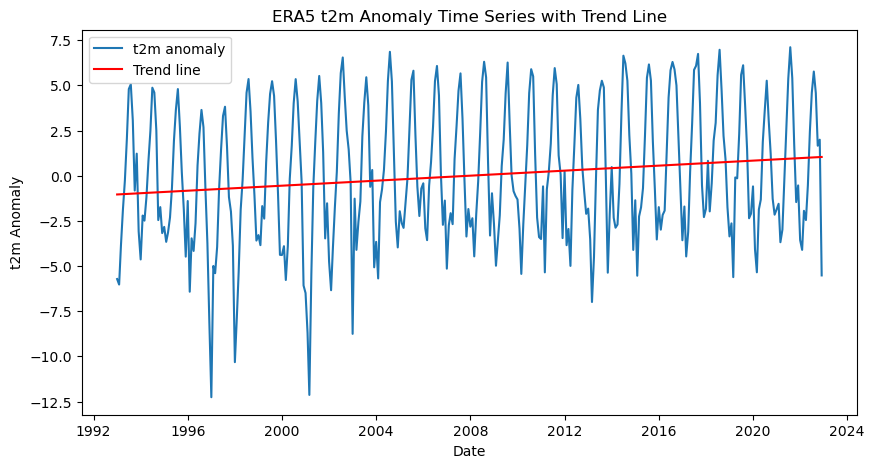

In [123]:
# Plot the time series

# Ensure the date column is in datetime format
ERA5_df['date'] = pd.to_datetime(ERA5_df["date"])

# Sort the dataframe by date
ERA5_df = ERA5_df.sort_values(by='date')
plt.figure(figsize=(10, 5))
plt.plot(ERA5_df['date'], ERA5_df['t2m_anomaly'], label='t2m anomaly')

# Compute the trend line
z = np.polyfit(ERA5_df.index, ERA5_df['t2m_anomaly'], 1)  # Fit a 1st degree polynomial (a line)
p = np.poly1d(z)

# Add trend line to the plot
plt.plot(ERA5_df['date'], p(ERA5_df.index), 'r', label='Trend line')

# Customize plot
plt.xlabel('Date')
plt.ylabel('t2m Anomaly')
plt.title('ERA5 t2m Anomaly Time Series with Trend Line')
plt.legend()

# Show the plot
plt.show()

#### Finally we plot below both t2m anomalies 

In [117]:
#ax=ERA5_df['t2m_anomaly'].plot(
#    figsize=(14,8),
#    fontsize=14,
#    legend=['ERA5'],
#    label="ERA5",
#    xlabel='\nYear',
#    ylabel='Temperature (Celcius)',
#    title='\nNear surface temperature anomaly for central Greenland from 1992 to 2022\n',
#    linestyle ="-"
#    )
#ts_carra_df['t2m_anomaly'].plot(
#    figsize=(14,8),
#    fontsize=14,
#    legend=['CARRA'],
#    label="CARRA",
#    xlabel='\nYear',
#    ylabel='Temperature (Celcius)',
#    title='\nNear surface temperature anomaly for central Greenland from 1992 to 2022\n',
#    linestyle ="-"
#    )#

#plt.legend()

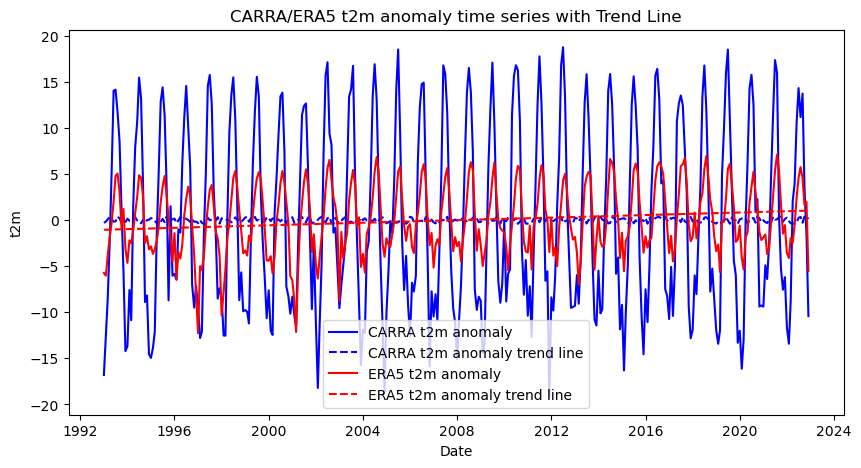

In [134]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(ts_carra_df['date'], ts_carra_df['t2m_anomaly'], label='CARRA t2m anomaly',color="blue")

# Compute the trend line
z = np.polyfit(ts_carra_df.index, ts_carra_df['t2m_anomaly'], 1)  # Fit a 1st degree polynomial (a line)
p = np.poly1d(z)

# Add trend line to the plot for CARRA
plt.plot(ts_carra_df['date'], p(ts_carra_df.index), color='blue',linestyle="--", label='CARRA t2m anomaly trend line')

plt.plot(ERA5_df['date'], ERA5_df['t2m_anomaly'], label='ERA5 t2m anomaly',color="red")

z_era5 = np.polyfit(ERA5_df.index, ERA5_df['t2m_anomaly'], 1)  # Fit a 1st degree polynomial (a line)
p_era5 = np.poly1d(z_era5)
plt.plot(ERA5_df['date'], p_era5(ERA5_df.index), 'r',linestyle="--", label='ERA5 t2m anomaly trend line')

# Customize plot
plt.xlabel('Date')
plt.ylabel('t2m')
plt.title('CARRA/ERA5 t2m anomaly time series with Trend Line')
plt.legend()

# Show the plot
plt.show()

Let's visualize the global near-surface air temperature anomaly for 2016 to see which regions were warmer or cooler compared to the reference period. This time we will make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a more customised figure. One of Cartopy's key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations.

#### Before reading the monthly files for the whole period we concatenate them
This is achieved by the bash script below, that is run in the same path as the data
```
con=()
for F in monthly_mean_no-ar-cw_an_sfc_??????.grib2; do
con+=($F)
done
cat ${con[@]} > monthly_mean_no-ar-cw_an_sfc_1993_2022.grib2

```

In [58]:
#The file below is a concatenated version of all the monthly files
t2m_carra_yearly = os.path.join(DATADIR,"monthly_means_carra","monthly_mean_no-ar-cw_an_sfc_1993_2022.grib2")

year_data=xr.open_dataset(t2m_carra_yearly)

In [56]:
#yearly_mean = da_degc.groupby('time.year').mean(keep_attrs=True)
yearly_mean = year_data["t2m"].groupby("time.year").mean()

In [57]:
t2m_2016 = yearly_mean.sel(year=2016)
ref_mean = yearly_mean.mean(dim="year")
anom_2016 = t2m_2016 - ref_mean

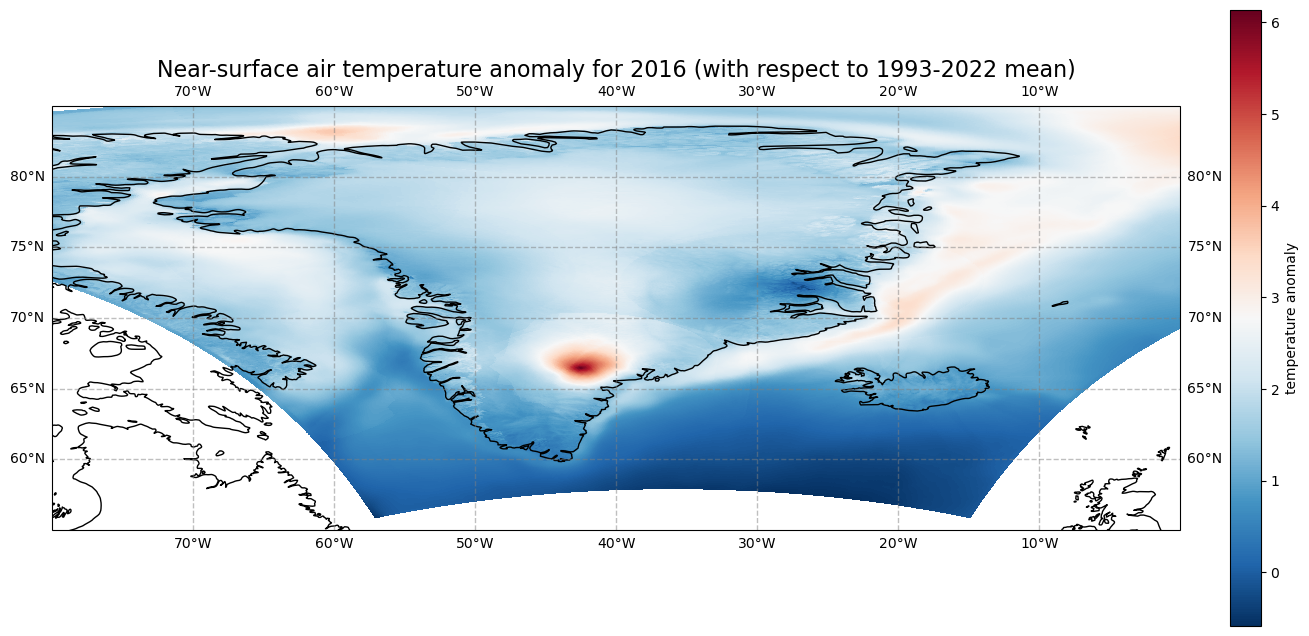

In [62]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(anom_2016.longitude, anom_2016.latitude, anom_2016, cmap='RdBu_r')#, vmin=-3, vmax=3) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('Near-surface air temperature anomaly for 2016 (with respect to 1993-2022 mean)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-80, 0, 55, 85], crs=ccrs.PlateCarree())

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

# Save the figure
#fig.savefig(f'{DATADIR}ERA5_global_2016_anomaly_eur.png')